# Climate Claim Classification: Zero-Shot vs. Few-Shot Learning

This notebook demonstrates and compares two advanced Natural Language Processing (NLP) paradigms – **Zero-Shot Learning (ZSL)** and **Few-Shot Learning (FSL)** – for the task of classifying climate-related claims. 

The goal is to distinguish, with claim-evidence pairs, whether the claim is related (1) or unrelated (0) to the evidence.

Data source: https://huggingface.co/datasets/mwong/climate-claim-related


## Table of Contents
1.  [Data Loading and Preparation](#1.-Data-Loading-and-Preparation)
2.  [Zero-Shot Learning (ZSL) with NLI](#2.-Zero-Shot-Learning-(ZSL)-with-NLI)
3.  [Few-Shot Learning (FSL) with SetFit](#3.-Few-Shot-Learning-(FSL)-with-SetFit)
4.  [Visualization: Confusion Matrices](#4.-Visualization:-Confusion-Matrices)

In [23]:
import pandas as pd
from datasets import load_dataset, Dataset
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from setfit import SetFitModel, SetFitTrainer, sample_dataset
from pprint import pprint

## 1. Data Loading and Preparation

### Data

In [ ]:
# --- 1. Load and Prepare Dataset ---
print("Loading 'mwong/climate-claim-related' dataset...")
dataset = load_dataset("mwong/climate-claim-related")
train_df = dataset['train']
val_df = dataset['valid']
test_df = dataset['test']

# Define label mapping for the identified classes
labels_map = {0: 'not related', 1: 'related'}
candidate_labels = list(labels_map.values())

# Convert the dataset to a pandas DataFrame for easier manipulation
train_df = train_df.to_pandas()
train_df['label_name'] = train_df['labels'].map(labels_map)

val_df = val_df.to_pandas()
val_df['label_name'] = val_df['labels'].map(labels_map)

test_df = test_df.to_pandas()
test_df['label_name'] = test_df['labels'].map(labels_map)

print("Actual labels in the training set:", train_df['label_name'].unique())

# --- 2. Basic EDA ---

# Check the length of each of the splits
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Check how balanced is the target across all splits
print("\nDistribution of labels in the training set:")
print(train_df['label_name'].value_counts(normalize=True))

print("\nDistribution of labels in the validation set:")
print(val_df['label_name'].value_counts(normalize=True))

print("\nDistribution of labels in the test set:")
print(test_df['label_name'].value_counts(normalize=True))

# --- 3. Extract validation and test data ---

# Extract claims and true labels for the validation set
val_claims = val_df['claim'].tolist()
val_evidence = val_df['evidence'].tolist()
y_val_true = val_df['label_name'].tolist()

# Extract claims and true labels for the test set
test_claims = test_df['claim'].tolist()
test_evidence = test_df['evidence'].tolist()
y_test_true = test_df['label_name'].tolist()

# Concatenate the claims and evidence for validation and test sets
val_concat_text = [f"Claim: {claim}\nEvidence: {evidence}" for claim, evidence in zip(val_claims, val_evidence)]
test_concat_text= [f"Claim: {claim}\nEvidence: {evidence}" for claim, evidence in zip(test_claims, test_evidence)]

# --- 4. Print 3 example claims, the evidence and the labels ---
print("\nExample claims and evidence from the test set:")
for i in range(3):
    print(f"Claim and evidence {i+1}:\n{test_concat_text[i]}")
    print(f"Label: {y_test_true[i]}\n")

Loading 'mwong/climate-claim-related' dataset...
Actual labels in the training set: ['related' 'not related']
Training set size: 12280
Validation set size: 2456
Test set size: 614

Distribution of labels in the training set:
label_name
related        0.5
not related    0.5
Name: proportion, dtype: float64

Distribution of labels in the validation set:
label_name
related        0.5
not related    0.5
Name: proportion, dtype: float64

Distribution of labels in the test set:
label_name
not related    0.5
related        0.5
Name: proportion, dtype: float64

Example claims and evidence from the validation set:
Claim and evidence 1:
Claim: A cold day in Chicago in winter has nothing to do with the trend of global warming.
Evidence: "A novel probabilistic forecast system predicting anomalously warm 2018–2022 reinforcing the long-term global warming trend".
Label: not related

Claim and evidence 2:
Claim: “…climate change will also reduce the number of cold days and cold spells.
Evidence: An a

i.e., the distribution of labels is exactly the same across all splits. This removes the need for doing stratified sampling, since the splits are already stratified.

### Utilities

In [38]:
def evaluate_classification(y_true, y_pred, base_filename, labels=None, probas=None, results_dir="results"):
    """
    Evaluates classification performance and saves visualization results
    
    Parameters:
    -----------
    y_true : list or array
        Ground truth labels
    y_pred : list or array
        Predicted labels
    base_filename : str
        Base name for saved files (e.g. "zero_shot", "few_shot")
    labels : list, optional
        List of class labels
    probas : array-like, optional
        Predicted probabilities for ROC and PR curves
    results_dir : str, optional
        Directory to save results
        
    Returns:
    --------
    dict: Dictionary containing metrics and report
    """
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                                roc_curve, auc, precision_recall_curve, average_precision_score)
    
    # Create results directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)
    
    # Ensure labels are provided
    if labels is None:
        labels = sorted(list(set(y_true)))
    
    # Check if model predicts only one class
    unique_predicted = set(y_pred)
    if len(unique_predicted) == 1:
        print(f"Warning: Model only predicts one class: {unique_predicted}")

    # 1. Classification report with accuracy
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, labels=labels, zero_division=0)  # Metric is set to zero for undefined cases
    report_with_acc = f"Accuracy: {accuracy:.4f}\n\n{report}"
    print(report_with_acc)
    
    # 2. Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {base_filename}')
    plt.tight_layout()
    cm_path = f"{results_dir}/{base_filename}_confusion_matrix.png"
    plt.savefig(cm_path, dpi=400)
    plt.show()
    plt.close()
    
    results = {
        "accuracy": accuracy,
        "report": report_with_acc,
        "saved_files": [cm_path]
    }
    
    # Process probabilities for ROC and PR curves if provided
    if probas is not None:
        # Convert labels to binary format for the curves
        unique_labels = sorted(list(set(y_true)))
        label_to_idx = {label: i for i, label in enumerate(unique_labels)}
        y_binary = np.array([label_to_idx[y] for y in y_true])
        y_score = probas
        
        # 3. ROC curve
        fpr, tpr, _ = roc_curve(y_binary, y_score)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {base_filename}')
        plt.legend(loc="lower right")
        plt.tight_layout()
        roc_path = f"{results_dir}/{base_filename}_roc_curve.png"
        plt.savefig(roc_path, dpi=400)
        plt.show()
        plt.close()
        results["saved_files"].append(roc_path)
        
        # 4. Precision-Recall curve
        precision, recall, _ = precision_recall_curve(y_binary, y_score)
        avg_precision = average_precision_score(y_binary, y_score)
        
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, color='blue', lw=2, 
                label=f'Precision-Recall (AP = {avg_precision:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title(f'Precision-Recall Curve - {base_filename}')
        plt.legend(loc="lower left")
        plt.tight_layout()
        pr_path = f"{results_dir}/{base_filename}_pr_curve.png"
        plt.savefig(pr_path, dpi=400)
        plt.show()
        plt.close()
        results["saved_files"].append(pr_path)
        
        # Add AUC metrics to results
        results["roc_auc"] = roc_auc
        results["avg_precision"] = avg_precision
    
    return results

## 2. Zero-Shot Learning (ZSL) with NLI

### With default NLI template

Running Zero-Shot Learning classification...


Device set to use cuda:0


Zero-Shot Learning predictions completed.

("Prediction 1: {'sequence': 'Claim: A cold day in Chicago in winter has "
 'nothing to do with the trend of global warming.\\nEvidence: "A novel '
 'probabilistic forecast system predicting anomalously warm 2018–2022 '
 'reinforcing the long-term global warming trend".\', \'labels\': [\'not '
 "related', 'related'], 'scores': [0.7414495944976807, 0.2585504353046417]}")
("Prediction 2: {'sequence': 'Claim: “…climate change will also reduce the "
 'number of cold days and cold spells.\\nEvidence: An alternative criticism is '
 'that the Church opposed particular scientific discoveries that it felt '
 'challenged its authority and power – particularly through the Reformation '
 "and on through the Enlightenment.', 'labels': ['related', 'not related'], "
 "'scores': [0.9925256371498108, 0.0074743423610925674]}")
("Prediction 3: {'sequence': 'Claim: Donald Trump thinks that climate change "
 'is a hoax, invented by the Chinese.\\nEvidence: With Gi

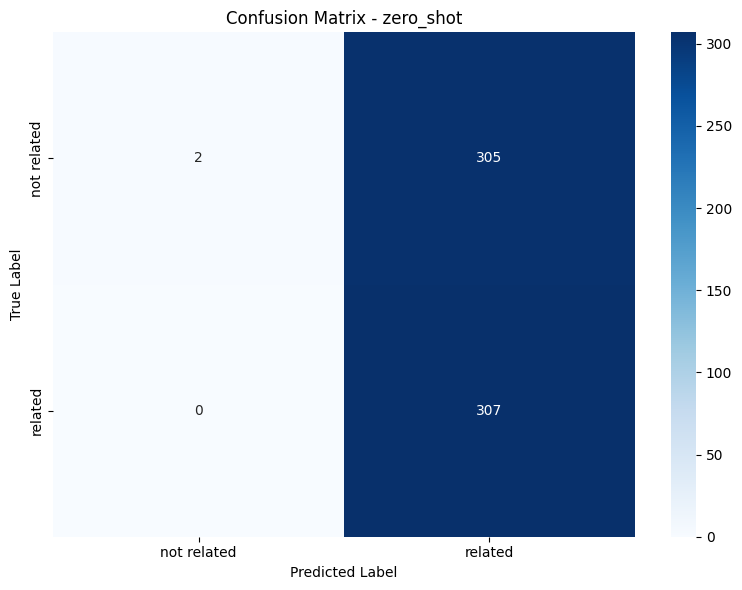

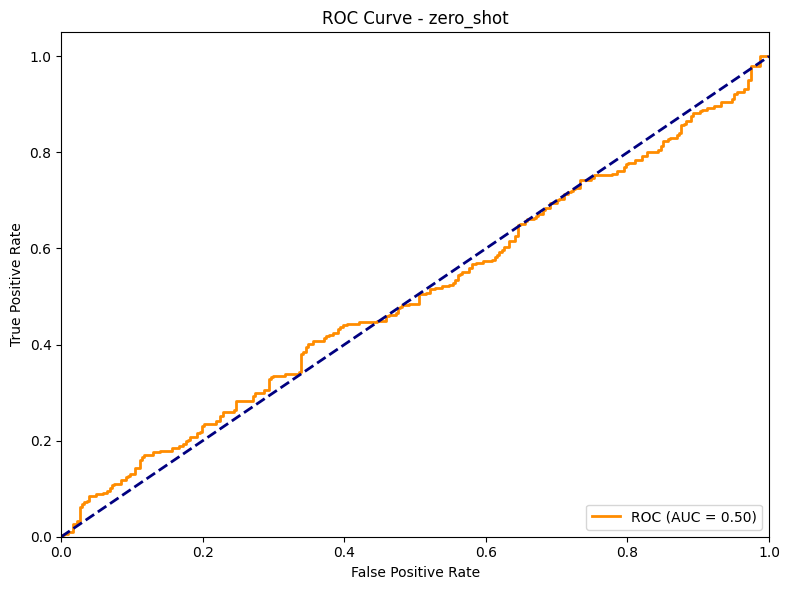

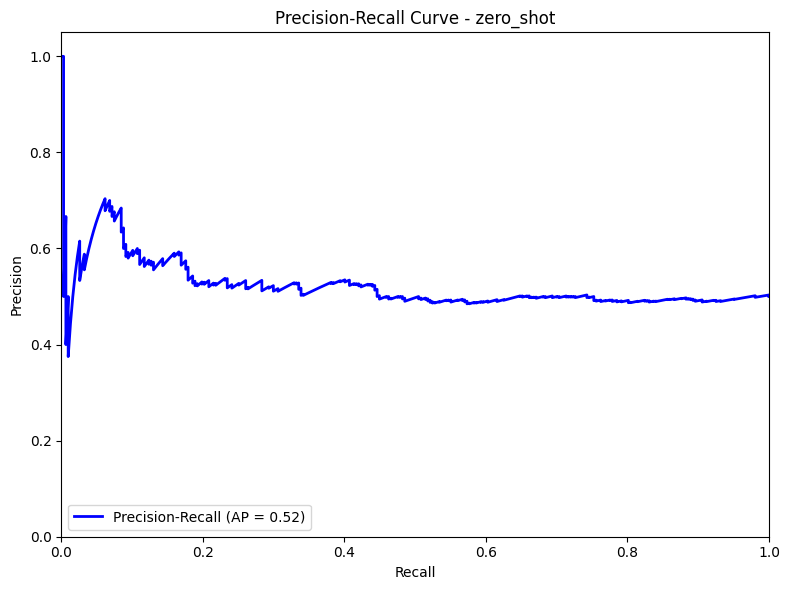

In [ ]:
print("Running Zero-Shot Learning classification...")
zsl_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

zsl_preds_raw = zsl_classifier(  # Automatically classify the claims based on the evidence, using a hypothesis template
    test_concat_text,  # Pass the claim-evidence pairs as a single text input
    candidate_labels=candidate_labels,  # Candidate labels for classification in natural language
    multi_label=False,  # False since a claim-evidence pair can only belong to one class
)
print("Zero-Shot Learning predictions completed.\n")

# Extract predictions and probabilities
y_pred_zsl = [pred['labels'][0] for pred in zsl_preds_raw]

# Extract probabilities for the positive class ('related')
zsl_probas = []
for pred in zsl_preds_raw:
    # Find the index of 'related' in the labels list
    related_idx = pred['labels'].index('related')
    # Get the corresponding score
    related_prob = pred['scores'][related_idx]
    zsl_probas.append(related_prob)

# Print the first 3 predictions and their probabilities
for i in range(3):
    pprint(f"Prediction {i+1}: {zsl_preds_raw[i]}")

# Evaluate the zero-shot learning results
zsl_results = evaluate_classification(
    y_true=y_test_true,
    y_pred=y_pred_zsl,
    base_filename="zero_shot_nli",
    labels=candidate_labels,
    probas=zsl_probas,
    results_dir="results"
)

### With custom NLI template

Running Zero-Shot Learning classification...


Device set to use cuda:0


Zero-Shot Learning predictions completed.

("Prediction 1: {'sequence': 'Claim: A cold day in Chicago in winter has "
 'nothing to do with the trend of global warming.\\nEvidence: "A novel '
 'probabilistic forecast system predicting anomalously warm 2018–2022 '
 'reinforcing the long-term global warming trend".\', \'labels\': '
 "['related', 'not related'], 'scores': [0.7698357105255127, "
 '0.2301642894744873]}')
("Prediction 2: {'sequence': 'Claim: “…climate change will also reduce the "
 'number of cold days and cold spells.\\nEvidence: An alternative criticism is '
 'that the Church opposed particular scientific discoveries that it felt '
 'challenged its authority and power – particularly through the Reformation '
 "and on through the Enlightenment.', 'labels': ['related', 'not related'], "
 "'scores': [0.9883836507797241, 0.011616337113082409]}")
("Prediction 3: {'sequence': 'Claim: Donald Trump thinks that climate change "
 'is a hoax, invented by the Chinese.\\nEvidence: With 

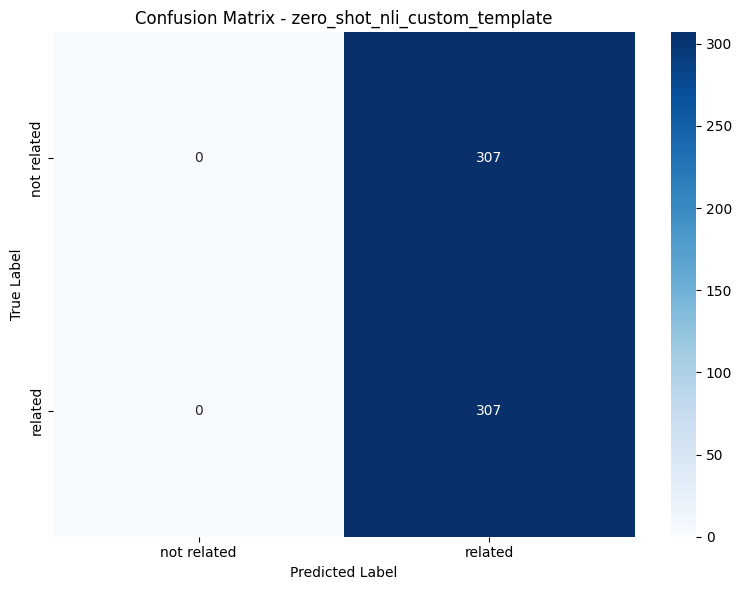

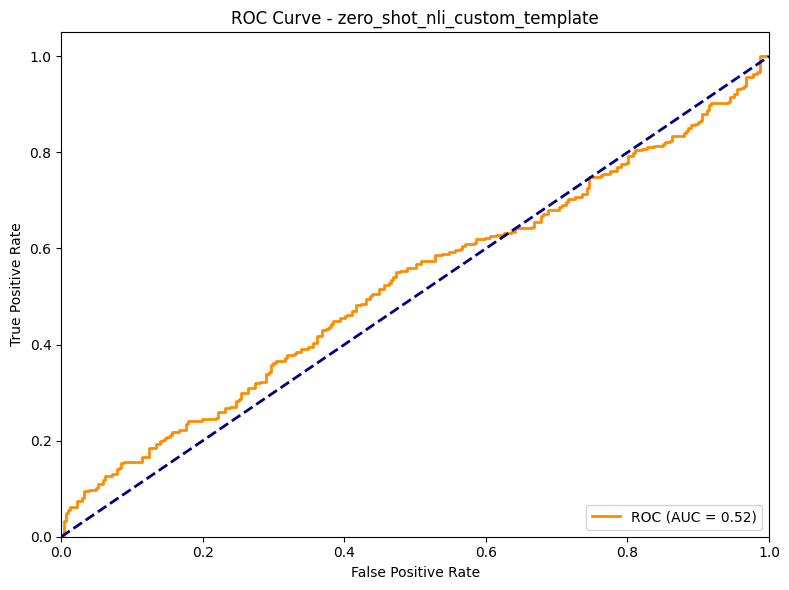

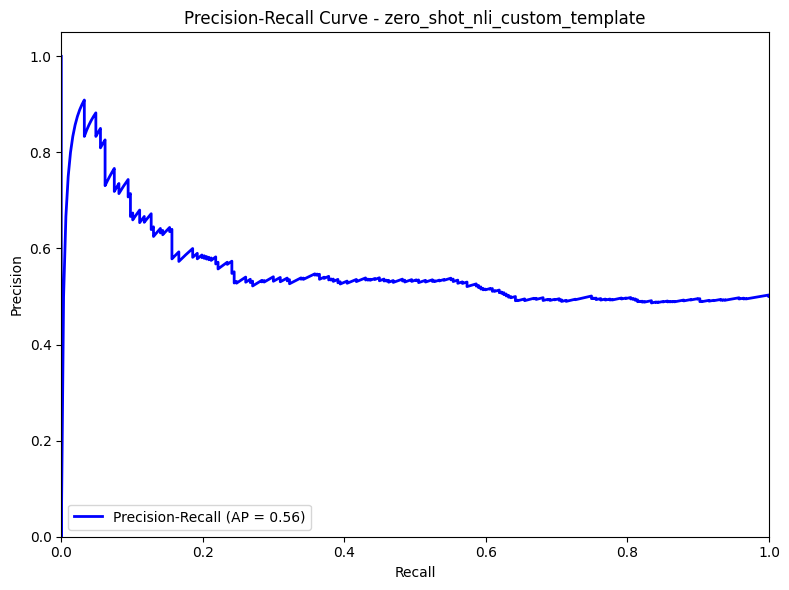

In [39]:
print("Running Zero-Shot Learning classification...")
zsl_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

zsl_preds_raw = zsl_classifier(
    test_concat_text,  # Pass the claim-evidence pairs as a single text input
    candidate_labels=candidate_labels,  # Candidate labels for classification in natural language
    multi_label=False,  # False since a claim-evidence pair can only belong to one class
    hypothesis_template="This claim is {} to the evidence."  # Automatically creates hypotheses from candidate labels
)
print("Zero-Shot Learning predictions completed.\n")

# Extract predictions and probabilities
y_pred_zsl = [pred['labels'][0] for pred in zsl_preds_raw]

# Extract probabilities for the positive class ('related')
zsl_probas = []
for pred in zsl_preds_raw:
    # Find the index of 'related' in the labels list
    related_idx = pred['labels'].index('related')
    # Get the corresponding score
    related_prob = pred['scores'][related_idx]
    zsl_probas.append(related_prob)

# Print the first 3 predictions and their probabilities
for i in range(3):
    pprint(f"Prediction {i+1}: {zsl_preds_raw[i]}")

# Evaluate the zero-shot learning results
zsl_results = evaluate_classification(
    y_true=y_test_true,
    y_pred=y_pred_zsl,
    base_filename="zero_shot_nli_custom_template",
    labels=candidate_labels,
    probas=zsl_probas,
    results_dir="results"
)

## 3. Few-Shot Learning (FSL)

### With a "generic" pre-trained Language Model and SetFit

In [ ]:
print("\nRunning Few-Shot Learning classification...")

# Prepare data for SetFit: it expects columns 'text' and 'label'.
train_df_for_fsl = train_df.rename(columns={'claim': 'text', 'labels': 'label'})
train_dataset_for_fsl = Dataset.from_pandas(train_df_for_fsl[['text', 'label']])

# Sample 8 examples per class for training the SetFit model
train_dataset_8shot = sample_dataset(train_dataset_for_fsl, label_column="label", num_samples=8)

# Load a pre-trained Sentence Transformer model as the base for SetFit
fsl_model = SetFitModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

# Initialize the SetFit trainer
trainer = SetFitTrainer(
    model=fsl_model,
    train_dataset=train_dataset_8shot,
    metric="accuracy",
    batch_size=8,
    num_iterations=100,
    num_epochs=5
)

# Train the SetFit model
trainer.train()

# Make predictions on the test set
fsl_predictions_numeric = trainer.model.predict(test_claims)

# Convert tensor predictions to integers before mapping back to label names
y_pred_fsl = [labels_map[label.item()] for label in fsl_predictions_numeric]

print("\n--- Few-Shot Learning (8-shot) Results ---")
print(classification_report(y_test_true, y_pred_fsl, labels=candidate_labels))


Running Few-Shot Learning classification...


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/vd/tdjtsvvd6n9570nygscfprww0000gn/T/ipykernel_81189/386021113.py:14: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 3200
  Batch size = 8
  Num epochs = 5
/Users/alexmolin/dsdm/forecasting_and_nowcasting/hw2/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.375700
50,0.274400
100,0.234500
150,0.159900
200,0.024400
250,0.003400
300,0.002200
350,0.001700
400,0.001200
450,0.001000


/Users/alexmolin/dsdm/forecasting_and_nowcasting/hw2/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/alexmolin/dsdm/forecasting_and_nowcasting/hw2/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/alexmolin/dsdm/forecasting_and_nowcasting/hw2/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



--- Few-Shot Learning (8-shot) Results ---
              precision    recall  f1-score   support

     related       0.53      0.82      0.64       150
 not_related       0.59      0.26      0.36       150

    accuracy                           0.54       300
   macro avg       0.56      0.54      0.50       300
weighted avg       0.56      0.54      0.50       300



### Standard fine-tuning with a model pre-trained for fact-checking

The question here is: can regular fine-tuning with few shot learning overcome the performance of a generic pre-trained LM fine-tuned with SetFit?

For this task, we will be using the [albert-xlarge-vitaminc-mnli](https://huggingface.co/tals/albert-xlarge-vitaminc-mnli) model (explained in this [paper](https://aclanthology.org/2021.naacl-main.52/)), pre-trained on claims and actual evidence from Wikipedia revisions.